In [1]:
import pandas as pd
import numpy as np
import math
import quandl
from sklearn import preprocessing, model_selection, svm
from sklearn.linear_model import LinearRegression                                                            
import matplotlib.pyplot as plt
from matplotlib import style
import pickle 

In [3]:
df = quandl.get("CHRIS/CME_SP1")
df

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1982-04-21,116.35,117.60,116.05,117.45,NaN,117.45,3696.0,412.0
1982-04-22,117.00,118.40,117.00,117.90,NaN,117.90,2827.0,719.0
1982-04-23,118.40,119.75,118.25,119.65,NaN,119.65,2933.0,946.0
1982-04-26,119.30,120.60,118.65,120.55,NaN,120.55,2871.0,1084.0
1982-04-27,120.20,120.35,118.40,118.85,NaN,118.85,3854.0,1142.0
...,...,...,...,...,...,...,...,...
2021-06-23,NaN,4247.20,4231.60,NaN,-4.8,4231.40,2210.0,6989.0
2021-06-24,NaN,4261.40,NaN,NaN,24.7,4256.10,1640.0,8667.0
2021-06-25,NaN,4273.90,4254.60,NaN,15.2,4271.30,3080.0,9518.0


In [5]:
#df = df[['Open', 'High', 'Low', 'Last', 'Volume']]                    
df['HL_PCT'] = ((df['High'] - df['Low']) / df['Low'])                                                                                                                        
df['PCT_Change'] = ((df['Last'] - df['Open']) / df['Open'])
df = df[['Last', 'PCT_Change', 'HL_PCT', 'Volume']]

,Last,PCT_Change,HL_PCT,Volume
Date,,,,
1982-04-21,117.45,0.009454,0.013356,3696.0
1982-04-22,117.90,0.007692,0.011966,2827.0
1982-04-23,119.65,0.010557,0.012685,2933.0
1982-04-26,120.55,0.010478,0.016435,2871.0
1982-04-27,118.85,-0.011231,0.016470,3854.0
...,...,...,...,...
2021-06-23,NaN,NaN,0.003687,2210.0
2021-06-24,NaN,NaN,NaN,1640.0
2021-06-25,NaN,NaN,0.004536,3080.0


In [6]:
df.dropna(inplace = True)
df

C:\Users\Irha traders\AppData\Local\Temp\ipykernel_13616\1845998749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)


,Last,PCT_Change,HL_PCT,Volume
Date,,,,
1982-04-21,117.45,0.009454,0.013356,3696.0
1982-04-22,117.90,0.007692,0.011966,2827.0
1982-04-23,119.65,0.010557,0.012685,2933.0
1982-04-26,120.55,0.010478,0.016435,2871.0
1982-04-27,118.85,-0.011231,0.016470,3854.0
...,...,...,...,...
2020-03-09,2747.00,-0.045684,0.057431,14457.0
2020-03-10,2864.00,0.053949,0.069560,7449.0
2020-03-11,2741.50,-0.043574,0.060910,12342.0


In [12]:
forecast_cols = 'Last'
forecast_out = int(math.ceil(0.015 * len(df)))
df['label'] = df[forecast_cols].shift(-forecast_out)
df.tail()

C:\Users\Irha traders\AppData\Local\Temp\ipykernel_13616\437342069.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df[forecast_cols].shift(-forecast_out)


,Last,PCT_Change,HL_PCT,Volume,label
Date,,,,,
2020-03-09,2747.0,-0.045684,0.057431,14457.0,NaN
2020-03-10,2864.0,0.053949,0.069560,7449.0,NaN
2020-03-11,2741.5,-0.043574,0.060910,12342.0,NaN
2020-03-12,2468.0,-0.101435,0.127654,13599.0,NaN
2020-03-13,2695.0,0.030987,0.085542,13217.0,NaN


In [15]:
x = np.array(df.drop(['label'], axis = 1))
y = np.array(df['label'])
x = x[:-forecast_out]
y = y[:-forecast_out]
x_lately = x[-forecast_out:]
print(len(x), len(y), len(x_lately))

9388 9388 143


In [22]:
# x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.2)
# clf = LinearRegression()
# clf.fit(x_train, y_train)                                                            
#Pickling
with open('linearregression.pickle', 'wb') as file:
    pickle.dump(clf, file)
pickle_in = open('linearregression.pickle', 'rb')
clf = pickle.load(pickle_in)                      
accuracy = clf.score(x_test, y_test)
#accuracy
predictions = clf.predict(x_lately)
predictions

array([2745.91288749, 2776.39546292, 2756.33558137, 2751.33597154,
       2798.96284058, 2823.45685874, 2818.0345663 , 2834.70837694,
       2842.66252963, 2843.63644671, 2822.12783781, 2821.25741611,
       2821.42416208, 2861.20806666, 2864.29250815, 2860.0961432 ,
       2894.77128133, 2893.4711594 , 2901.71892362, 2892.5402342 ,
       2906.81947809, 2912.05823484, 2907.45562659, 2911.33533102,
       2904.34910964, 2921.12737236, 2911.77210844, 2906.28726266,
       2887.51974301, 2865.78991102, 2858.44767351, 2892.71274883,
       2902.29173542, 2925.02188751, 2920.38135283, 2956.86430986,
       2954.17592186, 2946.1928897 , 2983.73664253, 2935.3179083 ,
       2923.49558424, 2939.99868765, 2930.28532859, 2938.72515174,
       2956.37327109, 2987.9990708 , 2984.06415249, 2998.64894295,
       3000.94201523, 3013.67574946, 3016.49903506, 3001.92632865,
       3012.62002214, 3009.87586206, 3030.44313826, 3028.30672298,
       3029.28920196, 3020.43641076, 3028.06740375, 3031.87094

In [27]:
style.use('ggplot')
df['forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = pd.to_datetime(last_date)
next_unix = last_unix + pd.DateOffset(days = 1)

for i in predictions:
    next_date = next_unix
    next_unix += pd.DateOffset(days = 1)
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) -1)] + [i]

df.tail()

C:\Users\Irha traders\AppData\Local\Temp\ipykernel_13616\1198939910.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['forecast'] = np.nan
C:\Users\Irha traders\AppData\Local\Temp\ipykernel_13616\1198939910.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[next_date] = [np.nan for _ in range(len(df.columns) -1)] + [i]
C:\Users\Irha traders\AppData\Local\Temp\ipykernel_13616\1198939910.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

,Last,PCT_Change,HL_PCT,Volume,label,forecast
Date,,,,,,
2020-07-30,NaN,NaN,NaN,NaN,NaN,3057.268017
2020-07-31,NaN,NaN,NaN,NaN,NaN,2973.452715
2020-08-01,NaN,NaN,NaN,NaN,NaN,2969.510338
2020-08-02,NaN,NaN,NaN,NaN,NaN,3011.520144
2020-08-03,NaN,NaN,NaN,NaN,NaN,3044.705660


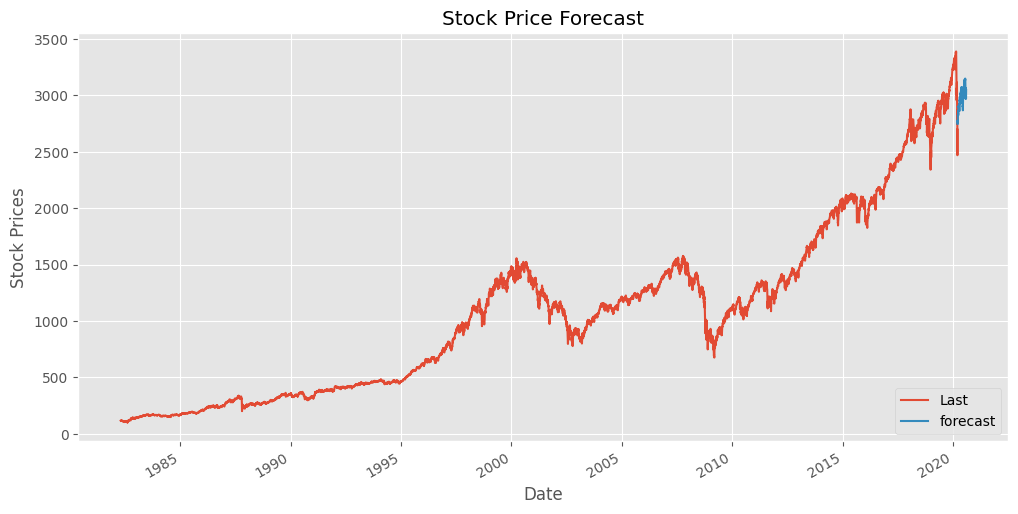

In [31]:
#Plotting
plt.figure(figsize=(12,6))
df['Last'].plot()
df['forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Stock Prices')
plt.title('Stock Price Forecast')
plt.show()